<a href="https://colab.research.google.com/github/ImagingDataCommons/idc-medima-paper/blob/main/nnunet/notebooks/idc_nnunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys

# useful information

curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

print("Python version    :", sys.version.split('\n')[0])

Current directory : /content
Hostname          : 2e6cb516d165
Username          : root
Python version    : 3.7.12 (default, Jan 15 2022, 18:48:18) 



# Data Download and Preparation

## Environment Setup

In [ ]:
!mkdir -p src data models output

# add GitHub to the list of known hosts
#!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# FIXME: it we create, as we should, repository for this project,
#        then we can (and will!) include dicomsort and all the other
#        libraries (nnU-Net maybe, PyPlastimatch, etc.) as submodules
#        so only one "git clone" operation will be necessary

# clone the repositories we need to run the pipeline
!git clone https://github.com/pieper/dicomsort src/dicomsort

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
# FIXME: this will get added in the requirements.txt file,
#        so it won't be necessary to run this once we set up the repo
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


In [ ]:
import pandas as pd

from google.cloud import bigquery as bq

If the users want to download a cohort starting from table you created using your Google account and the IDC portal (free!), they will need to log their Google account to this Colab Instance.

<br>

_(FIXME: easily fixed making some of these tables public before publication; e.g., under `canceridc-data > blablabla`)_

_(FIXME: modify the next cell if we want to use CSV files as well/instead)_

In [ ]:
# FIXME: remove once such tables are public
from google.colab import auth
auth.authenticate_user()

In [ ]:
# FIXME: this won't be needed once we have a git repository to clone
#        doing like this rn just for debug purposes!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
src_base_path = "/content/drive/MyDrive/AIM/Projects/IDC/idc-nnunet/src"

# copy the scripts in the src directory - where they will be in the repo
!cp -r $src_base_path/segthor/* src

chmod: cannot access '/content/src/run_inference.sh': No such file or directory


## Parsing Cohort Information from BigQuery Tables

In [ ]:
# name of the project
PROJECT_NAME = "idc-sandbox-000"

# name of the BQ dataset where the table is copied
DATASET_NAME = "dennis_cohorts"

# name of the BQ table copied from IDC to the user's own project
TABLE_NAME = "nsclc-nnunet-he"

# Table ID to use with the BQ command
TABLE_ID = "%s.%s.%s"%(PROJECT_NAME, DATASET_NAME, TABLE_NAME)

In [ ]:
# the query we are going to execute to gather data about the selected cohort
query_str = "SELECT * FROM `%s`"%(TABLE_ID)

# init the BQ client
client = bq.Client(project = "idc-sandbox-000")

# run the query
query_job = client.query(query_str)

# convert the results to a Pandas dataframe
cohort_df = query_job.to_dataframe()

# FIXME: for debug purposes, only process a handful of patients for now
#pat_id_list = list(set(cohort_df["PatientID"].values))
#print("Total number of unique Patient IDs:", len(pat_id_list))

#pat_id_list_sliced = pat_id_list[:100]
#cohort_df = cohort_df[cohort_df["PatientID"].isin(pat_id_list_sliced)]

In [ ]:
# FIXME: for debug purposes, only process a handful of patients for now
pat_id_list = list(set(cohort_df["PatientID"].values))

print("Total number of unique Patient IDs:", len(pat_id_list))

display(cohort_df.info())

display(cohort_df.head())


Total number of unique Patient IDs: 357
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44157 entries, 0 to 44156
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientID           44157 non-null  object
 1   collection_id       44157 non-null  object
 2   source_DOI          44157 non-null  object
 3   StudyInstanceUID    44157 non-null  object
 4   SeriesInstanceUID   44157 non-null  object
 5   SOPInstanceUID      44157 non-null  object
 6   crdc_study_uuid     44157 non-null  object
 7   crdc_series_uuid    44157 non-null  object
 8   crdc_instance_uuid  44157 non-null  object
 9   gcs_url             44157 non-null  object
 10  idc_version         44157 non-null  object
dtypes: object(11)
memory usage: 3.7+ MB


None

,PatientID,collection_id,source_DOI,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,crdc_study_uuid,crdc_series_uuid,crdc_instance_uuid,gcs_url,idc_version
0,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2414242025218459804872...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,034324d3-0089-4726-bfbb-cd754febde6c,gs://idc-dev-cr/034324d3-0089-4726-bfbb-cd754f...,7.0
1,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2648221267343378996555...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,053d8545-4adf-44b9-9776-2f149b255796,gs://idc-dev-cr/053d8545-4adf-44b9-9776-2f149b...,7.0
2,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2483895798395217229931...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,065427e7-c0de-41f1-9cdb-2cd28ee2009c,gs://idc-dev-cr/065427e7-c0de-41f1-9cdb-2cd28e...,7.0
3,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2829070204870971800854...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,0799aa73-2587-4214-a22a-95d6bb323466,gs://idc-dev-cr/0799aa73-2587-4214-a22a-95d6bb...,7.0
4,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.3684779892051361103024...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,0caa0508-e7f0-4ab6-b514-1c035d1c34d9,gs://idc-dev-cr/0caa0508-e7f0-4ab6-b514-1c035d...,7.0


## Downloading the DICOM Files From the IDC Buckets

In [ ]:
# create the directory tree
!mkdir -p data/raw 
!mkdir -p data/raw/tmp data/raw/nsclc-radiomics
!mkdir -p data/raw/nsclc-radiomics/dicom

In [ ]:
gs_file_path = "gcs_paths.txt"

#cohort_df_sliced["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# FIXME: run the following for the full analysis!
cohort_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

In [ ]:
%%capture

"""
  This command will download approximately 30 GBs of DICOM files
  (i.e., all the patients included in the NSCLC-Radiomics/LUNG1 dataset
  for which a manual delineation of the heart OR the esophagus is available).
  
  As the total number of .dcm files to download is approximately 45'000,
  and the Google Colab instances are equipped with HDDs and single core CPU,
  this will likely take around 45 minutes.
""" 

# https://cloud.google.com/storage/docs/gsutil/commands/cp
!cat $gs_file_path | gsutil -u $PROJECT_NAME -m cp -Ir data/raw/tmp

To organise the data in a more human-understandable and, above all, standardized fashion, we will make use of [DICOMSort](https://github.com/pieper/dicomsort). DICOMSort is an open source tool for custom sorting and renaming of dicom files based on their specific DICOM tags. In our case, we will exploit DICOMSort to organise the DICOM data by `PatientID` and `Modality` - so that the final directory will look like the following:

```
raw/nsclc-radiomics/dicom/$PatientID
 └─── CT
       ├─── $SOPInstanceUID_slice0.dcm
       ├─── $SOPInstanceUID_slice1.dcm
       ├───  ...
       │
      RTSTRUCT 
       ├─── $SOPInstanceUID_RTSTRUCT.dcm
      SEG
       └─── $SOPInstanceUID_RTSEG.dcm

```

## Dataset Preparation (sorting)

In [ ]:
# run the DICOMSort command
!python src/dicomsort/dicomsort.py -u data/raw/tmp data/raw/nsclc-radiomics/dicom/%PatientID/%Modality/%SOPInstanceUID.dcm

# get rid of the temporary folder, storing the unsorted DICOM data 
# FIXME: uncomment the following when running the full analysis!
!rm -r data/raw/tmp

100% 44157/44157 [10:56<00:00, 67.21it/s] 
Files sorted


---

# Data Pre-processing

## Environment Setup

In [ ]:
%%capture
!apt install plastimatch

In [ ]:
# check plastimatch was correctly installed
!plastimatch --version

plastimatch version 1.7.0


In [ ]:
!git clone https://github.com/AIM-Harvard/pyplastimatch src/pyplastimatch

Cloning into 'src/pyplastimatch'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 333 (delta 31), reused 302 (delta 12), pack-reused 0
Receiving objects: 100% (333/333), 55.56 MiB | 24.87 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
!pip install SimpleITK
!pip install -U PyYAML

     |████████████████████████████████| 48.4 MB 1.3 MB/s 
     |████████████████████████████████| 596 kB 5.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Running PyPlastimatch

Pre-processing: from DICOM to NRRD etc.

In [ ]:
!cd src && python data_preproc.py

Prepare the dataset for processing (following the nnU-Net standard):

In [ ]:
!cd src && python dataset_prep.py

Processing patient 357/357 (LUNG1-422)... Done.


---

# Data Processing

## Environment Setup

In [ ]:
%%capture
!pip install nnunet

In [ ]:
# this will usually take between one and five minutes (but can sometimes take up to eight)
seg_model_url = "https://www.dropbox.com/s/m7es2ojn8h0ybhv/Task055_SegTHOR.zip?dl=0"
output_path = "models/Task055_SegTHOR.zip"

!wget -O $output_path $seg_model_url

--2022-02-23 11:13:04--  https://www.dropbox.com/s/m7es2ojn8h0ybhv/Task055_SegTHOR.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m7es2ojn8h0ybhv/Task055_SegTHOR.zip [following]
--2022-02-23 11:13:04--  https://www.dropbox.com/s/raw/m7es2ojn8h0ybhv/Task055_SegTHOR.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9a84a832bc54baf5d1e2d00d53.dl.dropboxusercontent.com/cd/0/inline/BgT68u3CCMJAQfO1hDdYH-3vylcaHcbsg2HVDmh-XmNwbMHtaW9usb7fEKYXLqJ4GmStU2S2dRLYu2n_0wVLaXB_o6gE8IyOKZBwpACEHUU4LsEdlsBMsONe4l_cQXbOoirsldQqy5HwG2CRk6ij3HBj/file# [following]
--2022-02-23 11:13:05--  https://uc9a84a832bc54baf5d1e2d00d53.dl.dropboxusercontent.com/cd/0/inline/BgT68u3CCMJAQfO1hDdYH-3vylcaHcbsg2HVDmh-XmNwbMHtaW9usb7fEKYXLqJ4

In [ ]:
os.environ["RESULTS_FOLDER"] = "/content/data/nnunet_output/"
os.environ["PATH_TO_MODEL_FILE"] = "/content/models/Task055_SegTHOR.zip"
os.environ["WEIGHTS_FOLDER"] = "/content/data/nnunet_output/nnUNet"
os.environ["PATH_TO_INPUT_DATA"] = "/content/data/model_input/"

In [ ]:
%%capture
!nnUNet_install_pretrained_model_from_zip $PATH_TO_MODEL_FILE

## Running the Inference

In [ ]:
# FIXME: set different "$RESULTS_FOLDER" variables and run the pipeline
#        using multiple models, then compare the results

# run the inference phase
# accepted options for --model are: 2d, 3d_lowres, 3d_fullres or 3d_cascade_fullres
!nnUNet_predict --input_folder $PATH_TO_INPUT_DATA \
                --output_folder $RESULTS_FOLDER \
                --task_name "Task055_SegTHOR" \
                --model 2d \
                --disable_tta 

## Data Post-processing

In [ ]:
!cd src && python pred_postproc.py

---

# Results Analysis

In [ ]:
import numpy as np
import SimpleITK as sitk

from scipy.stats import gaussian_kde

from src.pyplastimatch.pyplastimatch.utils import viz as viz_utils

# ----------------------------------------

# everything that has to do with plotting goes here below
import seaborn as sns
#sns.set(style = "whitegrid")

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from matplotlib.colors import ListedColormap

%matplotlib inline
#%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a "color overlay" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

## Visualizing the Segmentation Masks

In [ ]:
# FIXME: parse everything (at the start?) from the config file?
results_base_path = "/content/data/processed/nsclc-radiomics/nrrd/"
pat_to_viz = "LUNG1-078"

pat_nrrd_folder_path = os.path.join(results_base_path, pat_to_viz) 

ct_nrrd_path = os.path.join(pat_nrrd_folder_path, pat_to_viz + "_ct.nrrd")

In [ ]:
# load NRRD volumes
sitk_ct = sitk.ReadImage(ct_nrrd_path)
ct_nrrd = sitk.GetArrayFromImage(sitk_ct)

# inferred segmask 
# heart mask
pred_segmask_heart_path = os.path.join(pat_nrrd_folder_path, "pred_segmasks", "Heart.nrrd")
pred_segmask_heart = sitk.GetArrayFromImage(sitk.ReadImage(pred_segmask_heart_path))

# esophagus mask
pred_segmask_esophagus_path = os.path.join(pat_nrrd_folder_path, "pred_segmasks", "Esophagus.nrrd")
pred_segmask_esophagus = sitk.GetArrayFromImage(sitk.ReadImage(pred_segmask_esophagus_path))

# aorta mask
pred_segmask_aorta_path = os.path.join(pat_nrrd_folder_path, "pred_segmasks", "Aorta.nrrd")
pred_segmask_aorta = sitk.GetArrayFromImage(sitk.ReadImage(pred_segmask_aorta_path))

# trachea mask
pred_segmask_trachea_path = os.path.join(pat_nrrd_folder_path, "pred_segmasks", "Trachea.nrrd")
pred_segmask_trachea = sitk.GetArrayFromImage(sitk.ReadImage(pred_segmask_trachea_path))

# manual segmask (from the RTSTRUCT)
# heart mask
try: 
  rt_segmask_heart_path = os.path.join(pat_nrrd_folder_path, "rt_segmasks", "Heart.nrrd")
  rt_segmask_heart = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmask_heart_path))
except:
  # for the sake of simplicity, fill the volume with zeros
  rt_segmask_heart = np.zeros(pred_segmask_heart.shape)

# esophagus mask
try:
  rt_segmask_esophagus_path = os.path.join(pat_nrrd_folder_path, "rt_segmasks", "Esophagus.nrrd")
  rt_segmask_esophagus = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmask_esophagus_path))
except:
  # for the sake of simplicity, fill the volume with zeros
  rt_segmask_esophagus = np.zeros(pred_segmask_esophagus.shape)

In [ ]:
#sns.reset_orig()

_ = viz_utils.AxialSliceSegmaskComparison(ct_volume = ct_nrrd,
                                          segmask_ai_dict = {"Heart" : pred_segmask_heart,
                                                             "Esophagus" : pred_segmask_esophagus,
                                                             "Aorta" : pred_segmask_aorta,
                                                             "Trachea" : pred_segmask_trachea},
                                          segmask_manual_dict = {"Heart" : rt_segmask_heart,
                                                                 "Esophagus" : rt_segmask_esophagus},
                                          segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Esophagus" : my_reds,
                                                               "Aorta" : my_spring,
                                                               "Trachea" : my_blues},
                                          dpi = 100,
                                          title_left = "nnU-Net segmentation",
                                          title_right = "Manual segmentation",
                                          min_hu = -1024,
                                          max_hu = 1024)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## Computing and Visualizaing Segmentation Metrics

In [ ]:
!cd src && python eval.py

In [ ]:
output_base_path = "/content/output"

dc_heart_df_path = os.path.join(output_base_path, "dc_heart.csv")
dc_esophagus_df_path = os.path.join(output_base_path, "dc_esophagus.csv")

hd_heart_df_path = os.path.join(output_base_path, "hd_heart.csv")
hd_esophagus_df_path = os.path.join(output_base_path, "hd_esophagus.csv")

### Dice Coefficient

#### Heart

In [ ]:
dc_heart_df = pd.read_csv(dc_heart_df_path)

dc_heart_df = dc_heart_df.dropna()

display(dc_heart_df.info())
display(dc_heart_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 356
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  127 non-null    object 
 1   com_ref_x0  127 non-null    float64
 2   com_ref_x1  127 non-null    float64
 3   com_ref_x2  127 non-null    float64
 4   com_cmp_x0  127 non-null    float64
 5   com_cmp_x1  127 non-null    float64
 6   com_cmp_x2  127 non-null    float64
 7   dc          127 non-null    float64
dtypes: float64(7), object(1)
memory usage: 8.9+ KB


None

,Unnamed: 0,com_ref_x0,com_ref_x1,com_ref_x2,com_cmp_x0,com_cmp_x1,com_cmp_x2,dc
0,LUNG1-002,35.06620,-47.6561,-34.145,29.62450,-45.0538,-22.532,0.825208
1,LUNG1-003,34.57260,-94.0305,-242.700,32.80230,-90.3451,-237.000,0.898464
3,LUNG1-005,8.95082,-61.4241,-113.510,3.91251,-59.9573,-106.110,0.842881
4,LUNG1-006,6.88629,-49.4278,-60.001,6.52255,-46.6756,-60.560,0.931213
5,LUNG1-007,43.57490,-224.4810,-519.150,41.94930,-224.6580,-511.670,0.853184


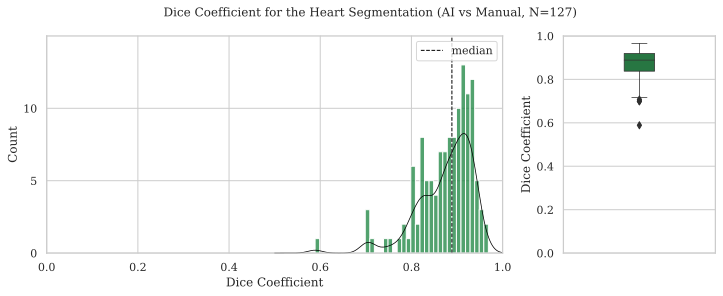

In [ ]:
fig, (ax_hist, ax_box)  = plt.subplots(1, 2, figsize = (12, 4),
                                       gridspec_kw = {'width_ratios': [3, 1]})

density = gaussian_kde(dc_heart_df["dc"].values)
xs = np.linspace(0.5, 1, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()

sns.histplot(x = "dc", data = dc_heart_df, binwidth = 0.01, ax = ax_hist, color = my_greens(200))
ax_hist.plot(xs, density(xs), color = "black", linewidth = .75)
ax_hist.vlines(np.median(dc_heart_df["dc"].values), linewidth = 1,
               ymin = 0, ymax = 20, colors = 'black', linestyles = 'dashed', label = "median")

ax_hist.set_xlabel("Dice Coefficient")
ax_hist.set_xlim([0, 1])

ax_hist.set_ylim([0, 15])
ax_hist.set_yticks(np.arange(0, 15, 5))

ax_hist.legend()

# ----------------------------------------

sns.boxplot(y = "dc", data = dc_heart_df, ax = ax_box, width = 0.2,
            linewidth = .75, color = my_greens(200))

ax_box.set_ylim([0, 1])
ax_box.set_ylabel("Dice Coefficient")

_ = fig.suptitle("Dice Coefficient for the Heart Segmentation (AI vs Manual, N=%g)\n"%(len(dc_heart_df)))

#### Esophagus

In [ ]:
dc_esophagus_df = pd.read_csv(dc_esophagus_df_path)

dc_esophagus_df = dc_esophagus_df.dropna()

display(dc_esophagus_df.info())
display(dc_esophagus_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 356
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  355 non-null    object 
 1   com_ref_x0  355 non-null    float64
 2   com_ref_x1  355 non-null    float64
 3   com_ref_x2  355 non-null    float64
 4   com_cmp_x0  355 non-null    float64
 5   com_cmp_x1  355 non-null    float64
 6   com_cmp_x2  355 non-null    float64
 7   dc          355 non-null    float64
dtypes: float64(7), object(1)
memory usage: 25.0+ KB


None

,Unnamed: 0,com_ref_x0,com_ref_x1,com_ref_x2,com_cmp_x0,com_cmp_x1,com_cmp_x2,dc
0,LUNG1-002,10.02020,-1.10146,29.832,6.53748,3.58699,40.2920,0.726804
1,LUNG1-003,8.32037,-28.81250,-179.870,9.07768,-28.68600,-191.2000,0.821415
2,LUNG1-004,5.45363,15.62310,-460.560,9.62117,18.68940,-483.1600,0.642563
3,LUNG1-005,-18.27490,-4.35119,-52.167,-18.22740,-3.74038,-57.1130,0.824940
4,LUNG1-006,-8.58888,26.87190,16.490,-9.72406,25.11340,-6.0309,0.807314


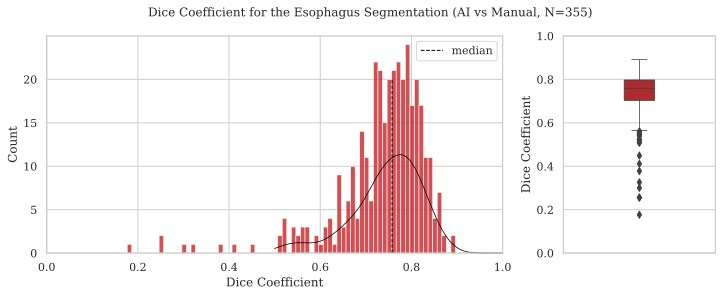

In [ ]:
fig, (ax_hist, ax_box)  = plt.subplots(1, 2, figsize = (12, 4),
                                       gridspec_kw = {'width_ratios': [3, 1]})

density = gaussian_kde(dc_esophagus_df["dc"].values)
xs = np.linspace(0.5, 1, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()

sns.histplot(x = "dc", data = dc_esophagus_df, binwidth = 0.01, ax = ax_hist, color = my_reds(200))
ax_hist.plot(xs, 2*density(xs), color = "black", linewidth = .75)
ax_hist.vlines(np.median(dc_esophagus_df["dc"].values), linewidth = 1,
               ymin = 0, ymax = 20, colors = 'black', linestyles = 'dashed', label = "median")

ax_hist.set_xlabel("Dice Coefficient")
ax_hist.set_xlim([0, 1])

ax_hist.set_ylim([0, 25])
ax_hist.set_yticks(np.arange(0, 25, 5))

ax_hist.legend()

# ----------------------------------------

sns.boxplot(y = "dc", data = dc_esophagus_df, ax = ax_box, width = 0.2,
            linewidth = 0.75, color = my_reds(200))

ax_box.set_ylim([0, 1])
ax_box.set_ylabel("Dice Coefficient")

_ = fig.suptitle("Dice Coefficient for the Esophagus Segmentation (AI vs Manual, N=%g)\n"%(len(dc_esophagus_df)))

## Hausdorff Coefficient (95th percentile)

#### Heart

In [ ]:
hd_heart_df = pd.read_csv(hd_heart_df_path)

# drop all the subject for which no DC for the heart is available
# (no manual annotation in the NSCLC-Radiomics dataset for the selected structure)
hd_heart_df = hd_heart_df.dropna()

# handle outliers values
hd_heart_df = hd_heart_df.mask(hd_heart_df["hd"] > 1000, 1000)
hd_heart_df = hd_heart_df.mask(hd_heart_df["hd95"] > 1000, 1000)

# drop patients for which the distance is enormous - for plotting purposes
dropped_hd95 = hd_heart_df[hd_heart_df["hd95"] > 150].index

# FIXME: for visualization purposes
print("Dropping %g patients (HD is too big --> error)"%len(dropped_hd95))

hd_heart_df = hd_heart_df.drop(dropped_hd95)

Dropping 0 patients (HD is too big --> error)


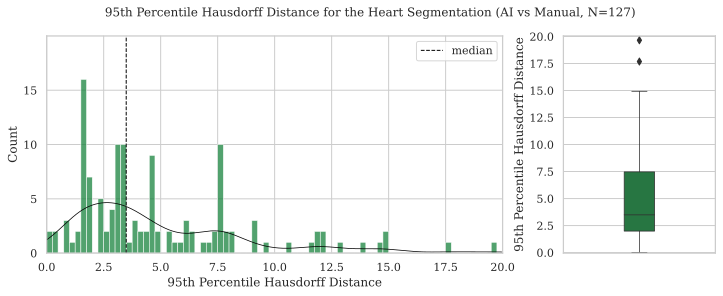

In [ ]:
fig, (ax_hist, ax_box)  = plt.subplots(1, 2, figsize = (12, 4),
                                       gridspec_kw = {'width_ratios': [3, 1]})

density = gaussian_kde(hd_heart_df["hd95"].values)
xs = np.linspace(0, 20, 1000)
density.covariance_factor = lambda : .25
density._compute_covariance()

sns.histplot(x = "hd95", data = hd_heart_df, binwidth = .25, ax = ax_hist, color = my_greens(200))
ax_hist.plot(xs, 30*density(xs), color = "black", linewidth = .75)
ax_hist.vlines(np.median(hd_heart_df["hd95"].values), linewidth = 1,
               ymin = 0, ymax = 20, colors = 'black', linestyles = 'dashed', label = "median")

ax_hist.set_xlabel("95th Percentile Hausdorff Distance")
ax_hist.set_xlim([0, 20])

ax_hist.set_ylim([0, 20])
ax_hist.set_yticks(np.arange(0, 20, 5))

ax_hist.legend()

# ----------------------------------------

sns.boxplot(y = "hd95", data = hd_heart_df, ax = ax_box, width = 0.2,
            linewidth = .75, color = my_greens(200))

ax_box.set_ylim([-0.05, 20.05])
ax_box.set_ylabel("95th Percentile Hausdorff Distance")

_ = fig.suptitle("95th Percentile Hausdorff Distance for the Heart Segmentation (AI vs Manual, N=%g)\n"%(len(hd_heart_df)))

#### Esophagus

In [ ]:
hd_esophagus_df = pd.read_csv(hd_esophagus_df_path)

# drop all the subject for which no DC for the heart is available
# (no manual annotation in the NSCLC-Radiomics dataset for the selected structure)
hd_esophagus_df = hd_esophagus_df.dropna()

# handle outliers values
hd_esophagus_df = hd_esophagus_df.mask(hd_esophagus_df["hd"] > 1000, 1000)
hd_esophagus_df = hd_esophagus_df.mask(hd_esophagus_df["hd95"] > 1000, 1000)

# drop patients for which the distance is enormous - for plotting purposes
dropped_hd95 = hd_esophagus_df[hd_esophagus_df["hd95"] > 150].index

# FIXME: for visualization purposes
print("Dropping %g patients (HD is too big --> error)"%len(dropped_hd95))

hd_esophagus_df = hd_esophagus_df.drop(dropped_hd95)

Dropping 0 patients (HD is too big --> error)


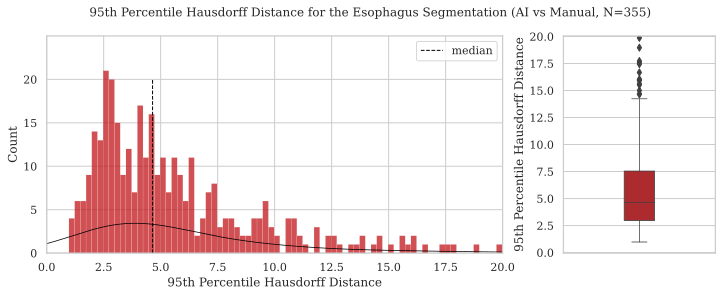

In [ ]:
fig, (ax_hist, ax_box)  = plt.subplots(1, 2, figsize = (12, 4),
                                       gridspec_kw = {'width_ratios': [3, 1]})

density = gaussian_kde(hd_esophagus_df["hd95"].values)
xs = np.linspace(0, 20, 1000)
density.covariance_factor = lambda : .25
density._compute_covariance()

sns.histplot(x = "hd95", data = hd_esophagus_df, binwidth = .25, ax = ax_hist, color = my_reds(200))
ax_hist.plot(xs, 30*density(xs), color = "black", linewidth = .75)
ax_hist.vlines(np.median(hd_esophagus_df["hd95"].values), linewidth = 1,
               ymin = 0, ymax = 20, colors = 'black', linestyles = 'dashed', label = "median")

ax_hist.set_xlabel("95th Percentile Hausdorff Distance")
ax_hist.set_xlim([0, 20])

ax_hist.set_ylim([0, 25])
ax_hist.set_yticks(np.arange(0, 25, 5))

ax_hist.legend()

# ----------------------------------------

sns.boxplot(y = "hd95", data = hd_esophagus_df, ax = ax_box, width = 0.2,
            linewidth = .75, color = my_reds(200))

ax_box.set_ylim([-0.05, 20.05])
ax_box.set_ylabel("95th Percentile Hausdorff Distance")

_ = fig.suptitle("95th Percentile Hausdorff Distance for the Esophagus Segmentation (AI vs Manual, N=%g)\n"%(len(hd_esophagus_df)))